In [313]:
from sklearn.datasets import make_circles

In [314]:
n_samples = 1000

In [315]:
x, y = make_circles(n_samples, noise=0.03, random_state=42)

In [316]:
import pandas as pd

In [317]:
circles = pd.DataFrame({'x':x[:,0], 'y':x[:,1], 'label':y})
circles

,x,y,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [318]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [319]:
import matplotlib.pyplot as plt

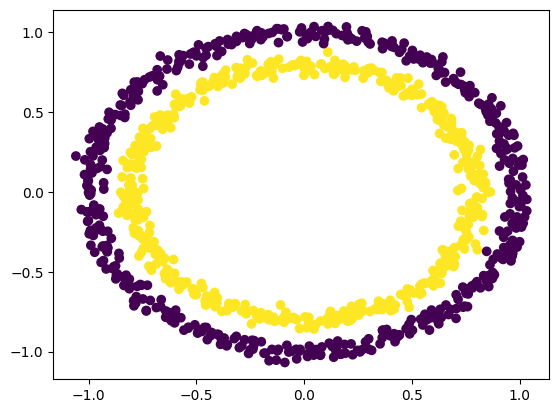

In [320]:
plt.scatter(circles['x'], circles['y'], c=circles['label'])

In [321]:
x.shape, y.shape

((1000, 2), (1000,))

In [322]:
import torch

In [323]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [324]:
from sklearn.model_selection import train_test_split

In [325]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [326]:
from torch import nn

In [327]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [328]:
class clf(nn.Module):
    def __init__(self):
        super().__init__()
        self.ll1 = nn.Linear(in_features = 2, out_features=5)
        self.ll2 = nn.Linear(in_features = 5, out_features=1)

    def forward(self, x):
        return self.ll2(self.ll1(x))


        

In [329]:
m0 = clf().to(device)
m0

clf(
  (ll1): Linear(in_features=2, out_features=5, bias=True)
  (ll2): Linear(in_features=5, out_features=1, bias=True)
)

In [330]:
m0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=5),
    nn.Linear(in_features = 5, out_features=1)
).to(device)
m0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [331]:
x_test.shape

torch.Size([200, 2])

In [332]:
untrained_preds = m0(x_test.to(device))
untrained_preds[:10], y_test[:10]

(tensor([[ 0.7963],
         [ 0.7420],
         [ 0.4967],
         [ 0.8831],
         [-0.2048],
         [-0.2325],
         [ 0.1706],
         [-0.0594],
         [ 0.5267],
         [ 0.7307]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [333]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = m0.parameters(), lr=0.1)

In [334]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = correct/(len(y_pred))*100
    return acc

In [335]:
y_logits = m0(x.to('cuda')[:5])

In [336]:
y_logits

tensor([[ 0.0737],
        [ 0.7324],
        [ 0.7687],
        [ 0.8095],
        [-0.2921]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [337]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5184],
        [0.6753],
        [0.6832],
        [0.6920],
        [0.4275]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [338]:
y_pred_labels = torch.round(y_pred_probs)
y_pred_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [339]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [340]:
y_pred_labels.squeeze()

tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [341]:
epochs = 100

In [342]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [343]:
import tqdm
from tqdm import trange

In [344]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [345]:
for epoch in trange(epochs):
    m0.train()

    y_logits = m0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    m0.eval()

    with torch.inference_mode():
        test_logits = m0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_Acc = accuracy_fn(test_pred, y_test)

    if epoch%10 == 0:
        print(f"training loss:{loss}, training accuracy:{acc}, test loss:{test_loss}, test accuracy:{test_Acc}")



 95%|█████████▌| 95/100 [00:00<00:00, 473.72it/s]

training loss:0.7246682643890381, training accuracy:52.125, test loss:0.7293830513954163, test accuracy:52.0
training loss:0.7130533456802368, training accuracy:51.5, test loss:0.7165908813476562, test accuracy:53.0
training loss:0.7063509821891785, training accuracy:51.24999999999999, test loss:0.7089803218841553, test accuracy:52.5
training loss:0.7022703886032104, training accuracy:50.875, test loss:0.7041929364204407, test accuracy:53.5
training loss:0.6996699571609497, training accuracy:50.5, test loss:0.7010362148284912, test accuracy:54.0
training loss:0.697948694229126, training accuracy:50.125, test loss:0.6988727450370789, test accuracy:53.5
training loss:0.6967728734016418, training accuracy:49.5, test loss:0.6973434090614319, test accuracy:54.0
training loss:0.6959487795829773, training accuracy:49.625, test loss:0.6962359547615051, test accuracy:55.00000000000001
training loss:0.6953582763671875, training accuracy:49.75, test loss:0.6954190135002136, test accuracy:54.0
tra

100%|██████████| 100/100 [00:00<00:00, 468.94it/s]


In [346]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


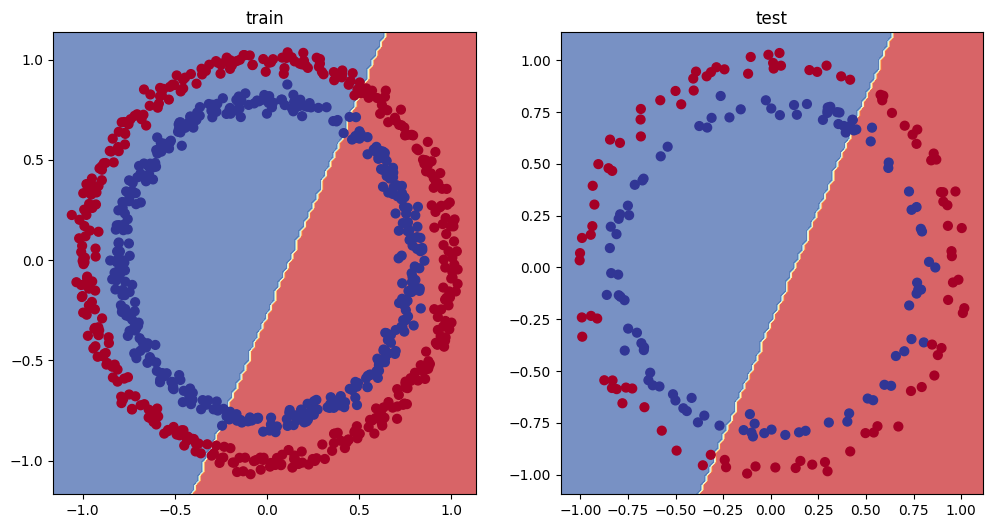

In [347]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(m0, x_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(m0, x_test, y_test)

In [348]:
m1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
).to(device)

m1

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [349]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(m1.parameters(), lr=0.1)

In [350]:
epochs=1000

In [351]:
x_train.shape

torch.Size([800, 2])

In [352]:
for epoch in range(epochs):
    m1.train()

    y_logits = m1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    m1.eval()

    with torch.inference_mode():
        y_test_logits = m1(x_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))

        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_test_pred, y_test)

    if epoch%100 ==0:
        print(f"train loss:{loss} | train acc: {acc} | test loss:{test_loss} | test acc : {test_acc}")

train loss:0.6986626386642456 | train acc: 50.0 | test loss:0.6976182460784912 | test acc : 50.0
train loss:0.6935994029045105 | train acc: 48.125 | test loss:0.6925972104072571 | test acc : 52.5
train loss:0.6928687691688538 | train acc: 48.25 | test loss:0.6921190023422241 | test acc : 52.0
train loss:0.6921311616897583 | train acc: 49.375 | test loss:0.691614031791687 | test acc : 52.5
train loss:0.6912362575531006 | train acc: 51.24999999999999 | test loss:0.6909727454185486 | test acc : 53.5
train loss:0.6901191473007202 | train acc: 55.125 | test loss:0.6902032494544983 | test acc : 54.50000000000001
train loss:0.6885806322097778 | train acc: 60.25 | test loss:0.6891665458679199 | test acc : 61.0
train loss:0.6865373253822327 | train acc: 57.62500000000001 | test loss:0.6879227161407471 | test acc : 55.00000000000001
train loss:0.6840018033981323 | train acc: 56.75 | test loss:0.6866471767425537 | test acc : 52.0
train loss:0.6807684302330017 | train acc: 56.125 | test loss:0.685

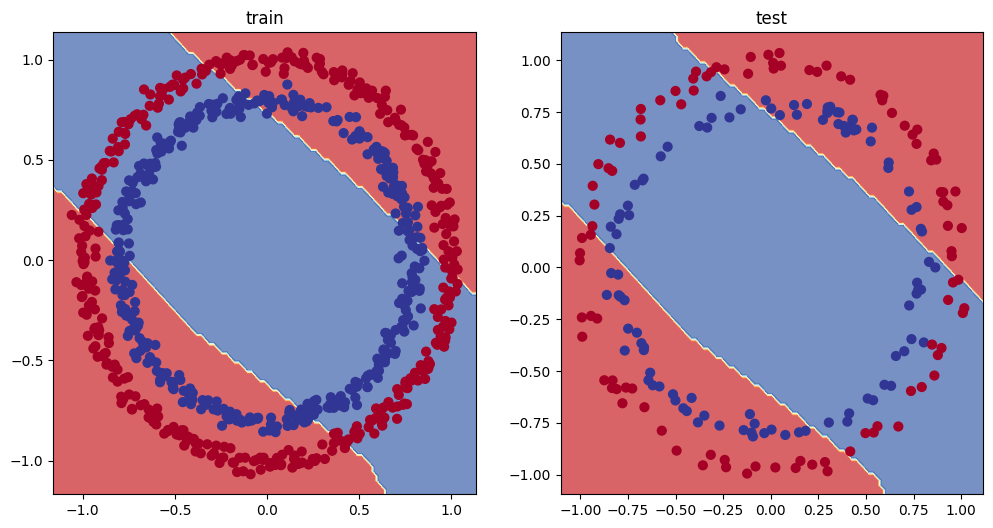

In [353]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(m1, x_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(m1, x_test, y_test)

In [354]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

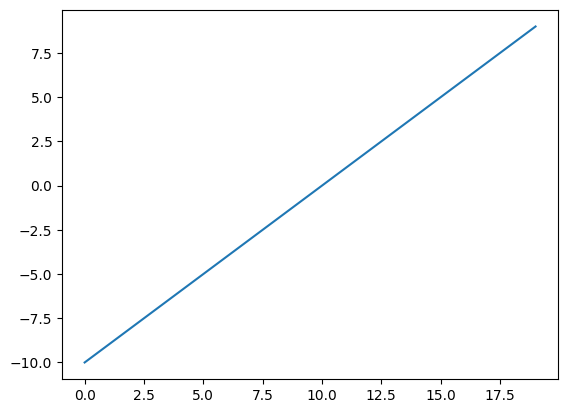

In [355]:
# Visualize the toy tensor
plt.plot(A);

In [356]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

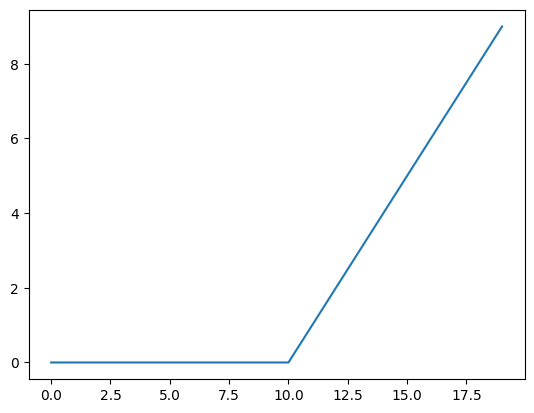

In [357]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [358]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

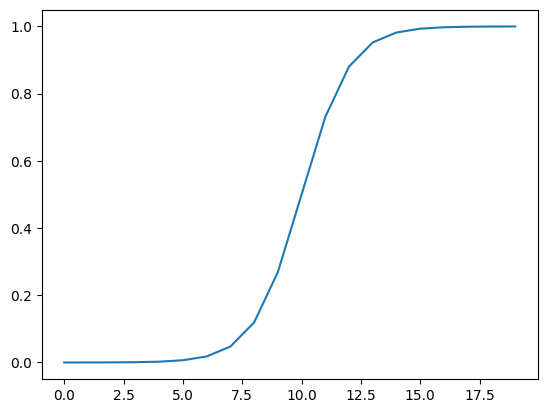

In [359]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A))

In [360]:
from sklearn.datasets import make_blobs


In [384]:
n_classes = 4
n_features = 2

In [385]:
x_blob, y_blob = make_blobs(n_samples=1000, n_features=n_features, centers=n_classes, cluster_std=1.1)

In [386]:
x_train, x_test, y_train, y_test = train_test_split(x_blob, y_blob, test_size=0.2)

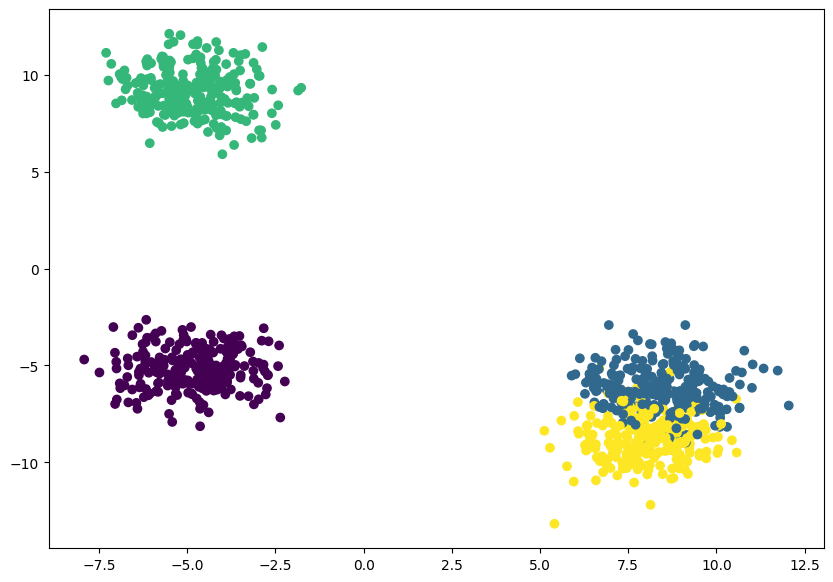

In [387]:
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0], x_blob[:,1], c=y_blob)

In [388]:
x_train[:5]

array([[ 9.1674565 , -6.45894512],
       [ 8.24028268, -7.23652904],
       [-5.04822172,  8.95008456],
       [ 9.3666663 , -5.3721305 ],
       [ 8.25583437, -6.23501903]])

In [389]:
class ModelGenerator(nn.Module):
    def __init__(self, input_features, hidden_neurons, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = n_features, out_features=hidden_neurons),
            #activation for non-linearity
            nn.Linear(in_features = hidden_neurons, out_features=hidden_neurons),
            #activation for non-linearity
            nn.Linear(in_features = hidden_neurons, out_features=n_classes),
        )

        
    
    def forward(self, x:torch.Tensor):
        return self.linear_layer_stack(x)



In [390]:
m2 = ModelGenerator(n_features, 10, n_classes).to(device)

In [391]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(m2.parameters(), lr=0.1)

In [392]:
x_train = torch.Tensor(x_train).type(torch.float).to(device)
x_test = torch.Tensor(x_test).type(torch.float).to(device)
y_train = torch.Tensor(y_train).type(torch.long).to(device)
y_test = torch.Tensor(y_test).type(torch.long).to(device)

In [393]:
epochs=100

In [394]:
m2(x_train)[:5], y_train[:5]

(tensor([[-1.7969, -1.8784,  3.1236, -1.5939],
         [-1.7566, -1.8102,  3.0279, -1.6588],
         [ 1.9049,  1.3052, -3.5848,  2.2766],
         [-1.7018, -1.8211,  2.9678, -1.4163],
         [-1.6458, -1.7340,  2.8399, -1.4818]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([3, 3, 2, 1, 1], device='cuda:0'))

In [395]:
for epoch in range(epochs):
    m2.train()

    y_logits = m2(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # print(y_logits[:5])
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)

    optim.zero_grad()

    loss.backward()

    optim.step()

    m2.eval()

    with torch.inference_mode():
        test_logits = m2(x_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test)

    if epoch%10==0:
        print(f"train loss:{loss} | train acc:{acc} | test loss:{test_loss} | test acc:{test_acc}")

train loss:4.363104343414307 | train acc:24.5 | test loss:1.529625415802002 | test acc:70.0
train loss:0.3458418548107147 | train acc:77.5 | test loss:0.35120728611946106 | test acc:74.5
train loss:0.3048548996448517 | train acc:82.875 | test loss:0.31963324546813965 | test acc:79.5
train loss:0.2682453691959381 | train acc:86.125 | test loss:0.2886212468147278 | test acc:85.5
train loss:0.24626213312149048 | train acc:87.0 | test loss:0.2672905921936035 | test acc:87.0
train loss:0.22907112538814545 | train acc:88.75 | test loss:0.2509791851043701 | test acc:88.0
train loss:0.21685513854026794 | train acc:89.5 | test loss:0.2387537807226181 | test acc:89.5
train loss:0.2070384919643402 | train acc:90.5 | test loss:0.22876912355422974 | test acc:91.0
train loss:0.20001012086868286 | train acc:90.625 | test loss:0.22163675725460052 | test acc:91.5
train loss:0.1945154368877411 | train acc:90.75 | test loss:0.21586425602436066 | test acc:91.5


In [396]:
y_pred[:10], y_test[:10]

(tensor([1, 3, 2, 1, 1, 3, 3, 0, 3, 3], device='cuda:0'),
 tensor([2, 1, 1, 2, 2, 0, 1, 2, 2, 3], device='cuda:0'))

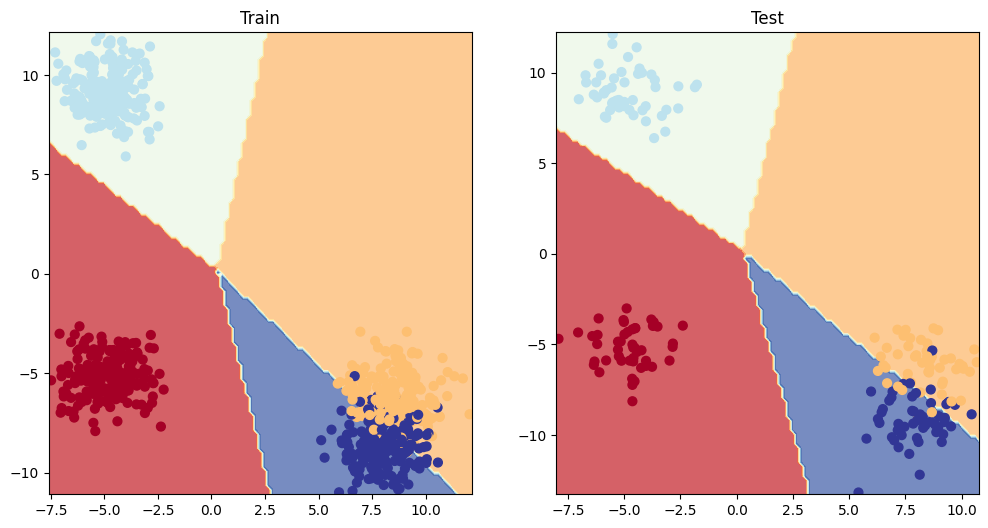

In [397]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(m2, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(m2, x_test, y_test)

In [399]:
from torchmetrics import Accuracy

In [400]:
accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

In [405]:
y_pred[:5], y_test[:5]

(tensor([1, 3, 2, 1, 1], device='cuda:0'),
 tensor([2, 1, 1, 2, 2], device='cuda:0'))

In [406]:
accuracy(test_pred, y_test)

tensor(0.9250, device='cuda:0')